### This Python notebook should sreve as an example of how to use tint
First import all modules that are needed

In [1]:
%matplotlib inline
import matplotlib
from tint import Cell_tracks, animate
import os, pandas as pd
from itertools import groupby
import numpy as np
from netCDF4 import Dataset as nc, num2date, date2num
from datetime import datetime, timedelta
from tint.helpers import get_times, get_grids
from tint.visualization import embed_mp4_as_gif, plot_traj
import warnings
warnings.filterwarnings("ignore")

### Define some important variables

In [2]:
dataF = os.path.join('data','CPOL_radar.nc') #NetCDF data file
trackdir = os.path.join('tracks') #Output directory
overwrite = True #Overwirte existing old files
first = '2006-11-16 03:00' #Start-date
last = '2006-11-16 11:00' #End-date

The application of the tracking algorithm constists of the following steps:
    1. read data and meta-data (from netCDF data)
    2. apply the tracking and save the ouput to a pandas-dataframe
    3. animate the tracking output

## The tuning parameters

The parameters play an important role when the tracking is applied to different datatypes (e.g satellite data).
The algorithm offers the following tunable parameters:


* FIELD_THRESH : The threshold used for object detection. Detected objects are connnected pixels above this threshold.
    
* ISO_THRESH : Used in isolated cell classification. Isolated cells must not be connected to any other cell by contiguous pixels above this threshold.
    
* ISO_SMOOTH : Gaussian smoothing parameter in peak detection preprocessing. See
    single_max in tint.objects.
* MIN_SIZE : The minimum size threshold in pixels for an object to be detected.
* SEARCH_MARGIN : The radius of the search box around the predicted object center.
* FLOW_MARGIN : The margin size around the object extent on which to perform phase correlation.
* MAX_DISPARITY : Maximum allowable disparity value. Larger disparity values are sent to LARGE_NUM.
* MAX_FLOW_MAG : Maximum allowable global shift magnitude.
* MAX_SHIFT_DISP :Maximum magnitude of difference in meters per second for two shifts to be
    considered in agreement.


### Open the netCDF file and apply the tracking

In [3]:
with nc(str(dataF)) as ncf:
        slices = get_times(ncf.variables['time'], first, last) #Get a subset of the data
        lats = ncf.variables['latitude'][:,0] #The latitude vector - 1D
        lons = ncf.variables['longitude'][0,:] # Tthe longitude vector - 1D
        # Define the centre of the domain
        x = lons[lons.shape[0] // 2]
        y = lats[lats.shape[0] // 2]
        grids = []
        for s in slices:
            ani = False
            #Create an iterator for the data dictionary 
            gr = (i for i in get_grids(ncf, s, lons, lats, varname='radar_estimated_rain_rate'))
            anim = (i for i in get_grids(ncf, s, lons, lats, varname='radar_estimated_rain_rate'))
            #Construct start and end date of slcie
            start = num2date(ncf.variables['time'][s[0]],
                             ncf.variables['time'].units)
            end = num2date(ncf.variables['time'][s[-1]],
                           ncf.variables['time'].units)
            #Filename suffix
            suffix = '%s-%s'%(start.strftime('%Y_%m_%d_%H'), end.strftime('%Y_%m_%d_%H'))
            tracks_obj = Cell_tracks()
            tracks_obj.params['MIN_SIZE'] = 4
            tracks_obj.params['FIELD_THRESH'] = 1
            track_file = os.path.join(trackdir,'tint_tracks_%s.h5'%suffix)
            if not os.path.isfile(track_file) or overwrite:
                ncells = tracks_obj.get_tracks(gr, (x, y))
                if ncells > 2 :
                    # Save tracks in handy hdf5 format for later analysis
                    tracks_obj.tracks.to_hdf(track_file, 'radar_tracks')
                    ani = True
                else:
                    ani = False
            animate(tracks_obj, anim, os.path.join(os.path.abspath(trackdir),'ani', 'tint_tracks_%s.mp4'%suffix), 
                    overwrite=overwrite, dt=9.5, tracers=True, basemap_res='f')

No cells found in scan 49     

time elapsed 0.0 minutes
Animating 49 frames
Frame: 49       

### Accessing the tracking data
 the tracks are saved in a dataframe and can be accessed by the ```.tracks``` instance:

In [5]:
tracks_obj.tracks.head(20)

time   grid_x  grid_y       lon      lat  area  \
scan uid                                                                  
0    0    2006-11-16 03:00:00    6.471  44.529  129.8419 -12.5382    17   
     1    2006-11-16 03:00:00    1.778  49.333  129.7495 -12.4483     9   
     2    2006-11-16 03:00:00  104.500  50.800  132.1082 -12.4033    10   
     3    2006-11-16 03:00:00   91.500  53.000  131.8307 -12.3583     6   
     4    2006-11-16 03:00:00   73.250  54.750  131.3913 -12.3134     4   
     5    2006-11-16 03:00:00   35.844  82.125  130.5357 -11.7064    96   
     6    2006-11-16 03:00:00   28.143  91.381  130.3507 -11.5041    21   
     7    2006-11-16 03:00:00   36.333  90.833  130.5357 -11.5041     6   
1    8    2006-11-16 03:10:00  104.909  50.636  132.1313 -12.4033    11   
     9    2006-11-16 03:10:00  108.800  50.600  132.2238 -12.4033     5   
     10   2006-11-16 03:10:00   95.500  52.000  131.9232 -12.3808     6   
     11   2006-11-16 03:10:00   76.714  53.000  131.4838 -12.3583     7   
     12   2006-11-16 03:10:00   88.000  52.714  131.7382 -12.3583     7   
     13   2006-11-16 03:10:00   73.000  55.000  131.3913 -12.3134     7   
     5    2006-11-16 03:10:00   72.650  86.600  131.3913 -11.5940    40   
     14   2006-11-16 03:10:00   78.071  92.571  131.5069 -11.4591    14   
     15   2006-11-16 03:10:00   97.500  95.000  131.9694 -11.4142     4   
     16   2006-11-16 03:10:00   91.500  98.125  131.8307 -11.3467     8   
2    17   2006-11-16 03:20:00  113.800  47.700  132.3394 -12.4708    10   
     18   2006-11-16 03:20:00   99.500  48.500  132.0157 -12.4708     4   

                max      mean  isolated  
scan uid                                 
0    0     1.451491  1.227551     False  
     1     1.398994  1.174826     False  
     2     5.279258  3.048147     False  
     3     3.560659  2.421517     False  
     4     2.505264  2.042082     False  
     5    31.694477  9.116140     False  
     6    28.975254  8.472269     False  
     7    10.012076  5.809241     False  
1    8     5.217285  3.262669     False  
     9     1.721878  1.453328     False  
     10    3.727539  2.343086     False  
     11    9.706904  3.791519     False  
     12    4.187761  2.103100     False  
     13   10.321914  4.560273     False  
     5    32.242092  9.384638     False  
     14   13.510443  6.020382     False  
     15    2.591437  2.371529     False  
     16    5.032235  2.767307     False  
2    17    5.353242  3.407234     False  
     18    1.403970  1.189312     False

### Saving the tracks for later analysis:
we can use pandas to save the track data and do a more in depth analysis on the storm systems later. The data can then also be loaded using pandas.

In [10]:
tracks_obj.tracks.to_hdf('/tmp/tint_tracks_%s.h5'%suffix, 'tracks')
table = pd.read_hdf('/tmp/tint_tracks_%s.h5'%suffix, 'tracks')
table.head()

time   grid_x  grid_y       lon      lat  area  \
scan uid                                                                  
0    0    2006-11-16 03:00:00    6.471  44.529  129.8419 -12.5382    17   
     1    2006-11-16 03:00:00    1.778  49.333  129.7495 -12.4483     9   
     2    2006-11-16 03:00:00  104.500  50.800  132.1082 -12.4033    10   
     3    2006-11-16 03:00:00   91.500  53.000  131.8307 -12.3583     6   
     4    2006-11-16 03:00:00   73.250  54.750  131.3913 -12.3134     4   

               max      mean  isolated  
scan uid                                
0    0    1.451491  1.227551     False  
     1    1.398994  1.174826     False  
     2    5.279258  3.048147     False  
     3    3.560659  2.421517     False  
     4    2.505264  2.042082     False

### Visualize the tracking output

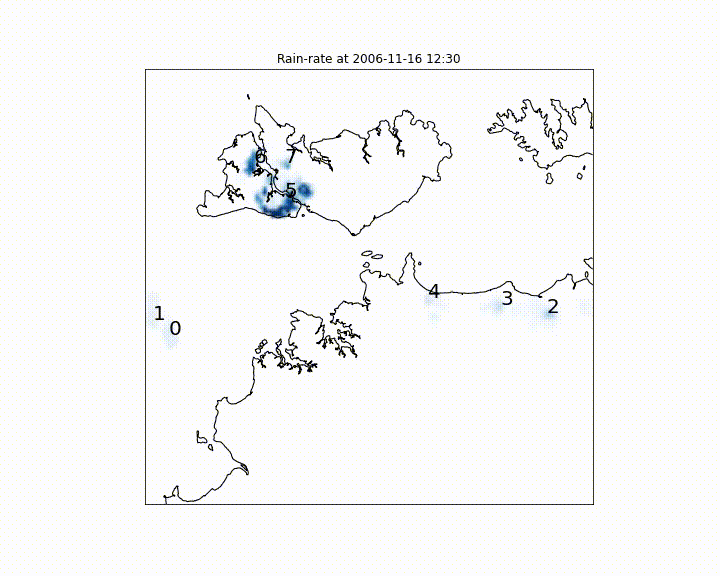

In [11]:
embed_mp4_as_gif(os.path.join(trackdir, 'ani', 'tint_tracks_%s.mp4'%suffix))

 Create a trace plot of the individually tracked objects

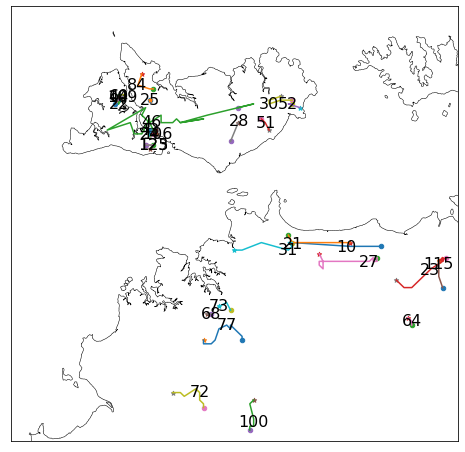

In [12]:
ax = plot_traj(tracks_obj.tracks, lons, lats, basemap_res='f', label=True, size=20)